### imports


In [3]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.metrics import RootMeanSquaredError, MeanSquaredError
from spektral.layers import GCNConv, GlobalSumPool
from spektral.models import GCN
from spektral.data import MixedLoader
from lorenz import lorenzDataset, DEFAULT_TIME_RESOLUTION
from plotters import plot_with_predictions, plot_true_vs_pred

2022-11-19 10:57:21.300803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


THINGS TO TRY 
- write helper functions! 
- play with diff sample size (500) - v
- input/output day ratio - h 
- play around with buffer - v
- activation layers - h
- play with the hidden layers - v 
- diff data samples / diff lorenz params - h 
- diff optimizer alg - v 

### helper functions for hyperparameter testing

In [4]:
def make_train_model(train,
                     channels=32,
                     activation="relu",
                     use_bias=False,
                     dropout_rate=0,
                     l2_reg=0,
                     optimizer='adam',
                     loss='mean_squared_error',
                     epochs=200):
    # prepare data
    train_loader = MixedLoader(dataset=train, batch_size=32)

    # create and train model
    GCN_model = GCN(
        n_labels=1,
        channels=channels,  # i.e. n_hidden layers in each GCNConv layer
        activation=activation,
        output_activation=None,  # we want regression, i.e. a linear function
        use_bias=use_bias,
        dropout_rate=dropout_rate,
        l2_reg=l2_reg)

    GCN_model.compile(optimizer=optimizer, loss=loss)

    history = GCN_model.fit(train_loader.load(),
                            steps_per_epoch=train_loader.steps_per_epoch,
                            epochs=epochs)
    return GCN_model, history


In [12]:
def plot_model_results(train, val, GCN_model, history, epochs=200):
    # plot training MSE
    fig_train_loss, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(history.history['loss'])
    ax.set_ylabel('mean squared error')
    ax.set_xlabel('epochs')
    fig_train_loss.suptitle('model MSE over training epochs')
    ax.text(x=epochs - 75,
            y=1.2 * history.history['loss'][-1],
            s="final loss: {:.2f}".format(history.history['loss'][-1]))
    ax.set_ylim(0, history.history['loss'][0]*1.1)

    # plot train predictions
    fig_train_pred, (ax0,
                     ax1) = plot_with_predictions(model=GCN_model,
                                                  graph_dataset=train,
                                                  Loader=MixedLoader,
                                                  batch_size=32,
                                                  node=0,
                                                  model_name='GCN OOTB train')

    # plot val predictions
    fig_val_pred, (ax0, ax1) = plot_with_predictions(model=GCN_model,
                                                     graph_dataset=val,
                                                     Loader=MixedLoader,
                                                     batch_size=32,
                                                     node=0,
                                                     model_name='GCN OOTB val')

    # # plot predictions against true value
    # fig_true_vs_pred, ax = plot_true_vs_pred(y_true, y_pred)

    plt.tight_layout()
    return fig_train_loss, fig_train_pred, fig_val_pred

### prepare data


In [7]:
# TODO: add logging to see progress

# only uncomment each line if testing a non-default parameter
dataset = lorenzDataset(
    n_samples=10000,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42
)

total steps: 10300
starting integration


In [8]:
train = dataset[:int(0.7 * dataset.n_graphs)]
val = dataset[int(0.7 * dataset.n_graphs):int(0.9 * dataset.n_graphs)]
test = dataset[int(0.9 * dataset.n_graphs):]

# normalize data
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()

train.normalize(X1_mean, X1_std, X2_mean, X2_std)
val.normalize(X1_mean, X1_std, X2_mean, X2_std)
test.normalize(X1_mean, X1_std, X2_mean, X2_std)

inspect our data

/var/folders/zz/zyxvpxvq6csfxvn_n00000s4000069/T/ipykernel_62581/2481617545.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/Guest/lorenzGNN/evenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


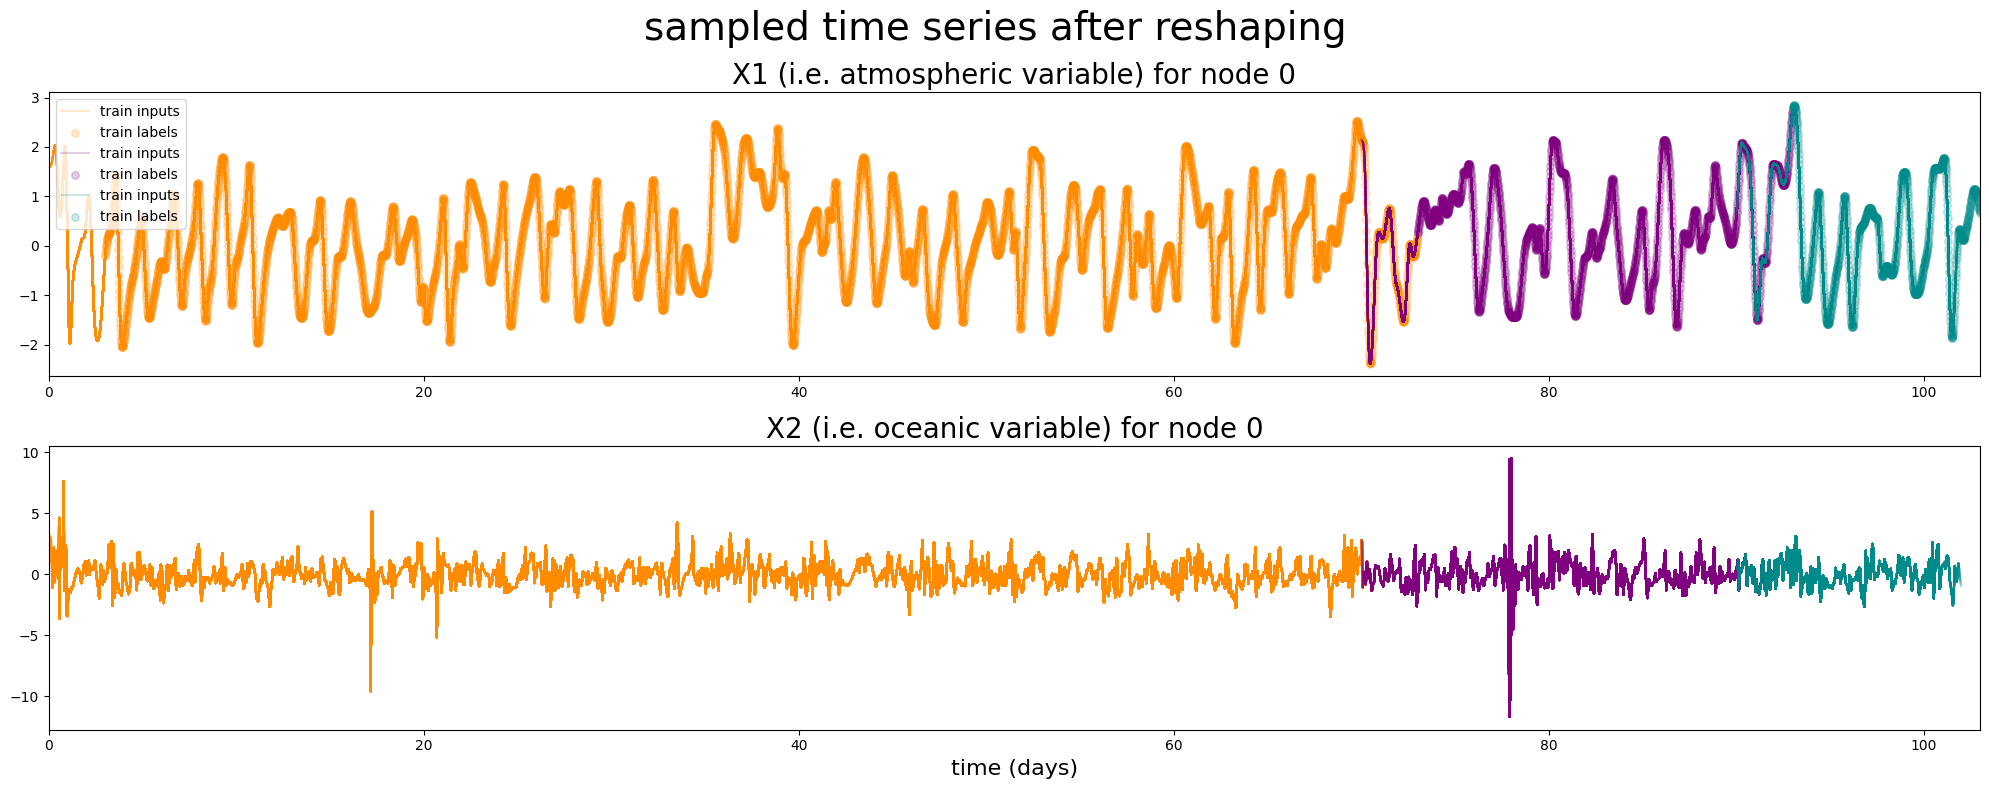

In [9]:
colors = ["darkorange", "purple", "darkcyan"]
node = 0

# set up plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))

fig.suptitle("sampled time series after reshaping", size=28)
ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
              size=20)
ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node), size=20)
plt.xlabel('time (days)', size=16)

# plot train, val, and test data
fig, (ax0, ax1) = train.plot(node,
                             fig,
                             ax0,
                             ax1,
                             data_type='train',
                             color=colors[0], alpha=0.2)
fig, (ax0, ax1) = val.plot(node,
                           fig,
                           ax0,
                           ax1,
                           data_type='val',
                           color=colors[1], alpha=0.2)
fig, (ax0, ax1) = test.plot(node,
                            fig,
                            ax0,
                            ax1,
                            data_type='test',
                            color=colors[2], alpha=0.2)

ax0.set_xlim(train[0].t_X[0], test[-1].t_Y[-1])
ax1.set_xlim(train[0].t_X[0], test[-1].t_Y[-1])

# create legend
ax0.legend()
ax0.legend(handles=ax0.get_legend().legendHandles[0:6])
leg = ax0.get_legend()
[
    leg.legendHandles[i].set_color(colors[i // 2])
    for i in range(len(leg.legendHandles))
]

plt.tight_layout()
plt.show()

### test hyperparameters

In [10]:
model, history = make_train_model(train, activation="relu")

2022-11-19 11:04:22.610699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Guest/lorenzGNN/evenv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'lorenzDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/200
219/219 [==============================] - 2s 5ms/step - loss: 3.0839
Epoch 2/200
219/219 [==============================] - 1s 5ms/step - loss: 1.3518
Epoch 3/200
219/219 [==============================] - 1s 4ms/step - loss: 1.1894
Epoch 4/200
219/219 [==============================] - 1s 4ms/step - loss: 1.1425
Epoch 5/200
219/219 [==============================] - 1s 4ms/step - loss: 1.0302
Epoch 6/200
219/219 [==============================] - 1s 4ms/step - loss: 1.0571
Epoch 7/200
219/219 [==============================] - 1s 4ms/step - loss: 1.0309
Epoch 8/200
219/219 [==============================] - 1s 4ms/step - loss: 0.9864
Epoch 9/200
219/219 [==============================] - 1s 4ms/step - loss: 0.9855
Epoch 10/200
219/219 [==============================] - 1s 4ms/step - loss: 0.9996
Epoch 11/200
219/219 [==============================] - 1s 4ms/step - loss: 0.9791
Epoch 12/200
219/219 [==============================] - 1s 4ms/step - loss: 0.9576
Epoch 13/200


32/32 [==============================] - 0s 4ms/step


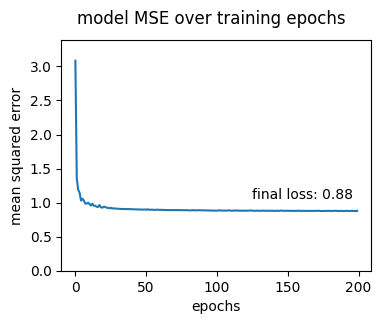

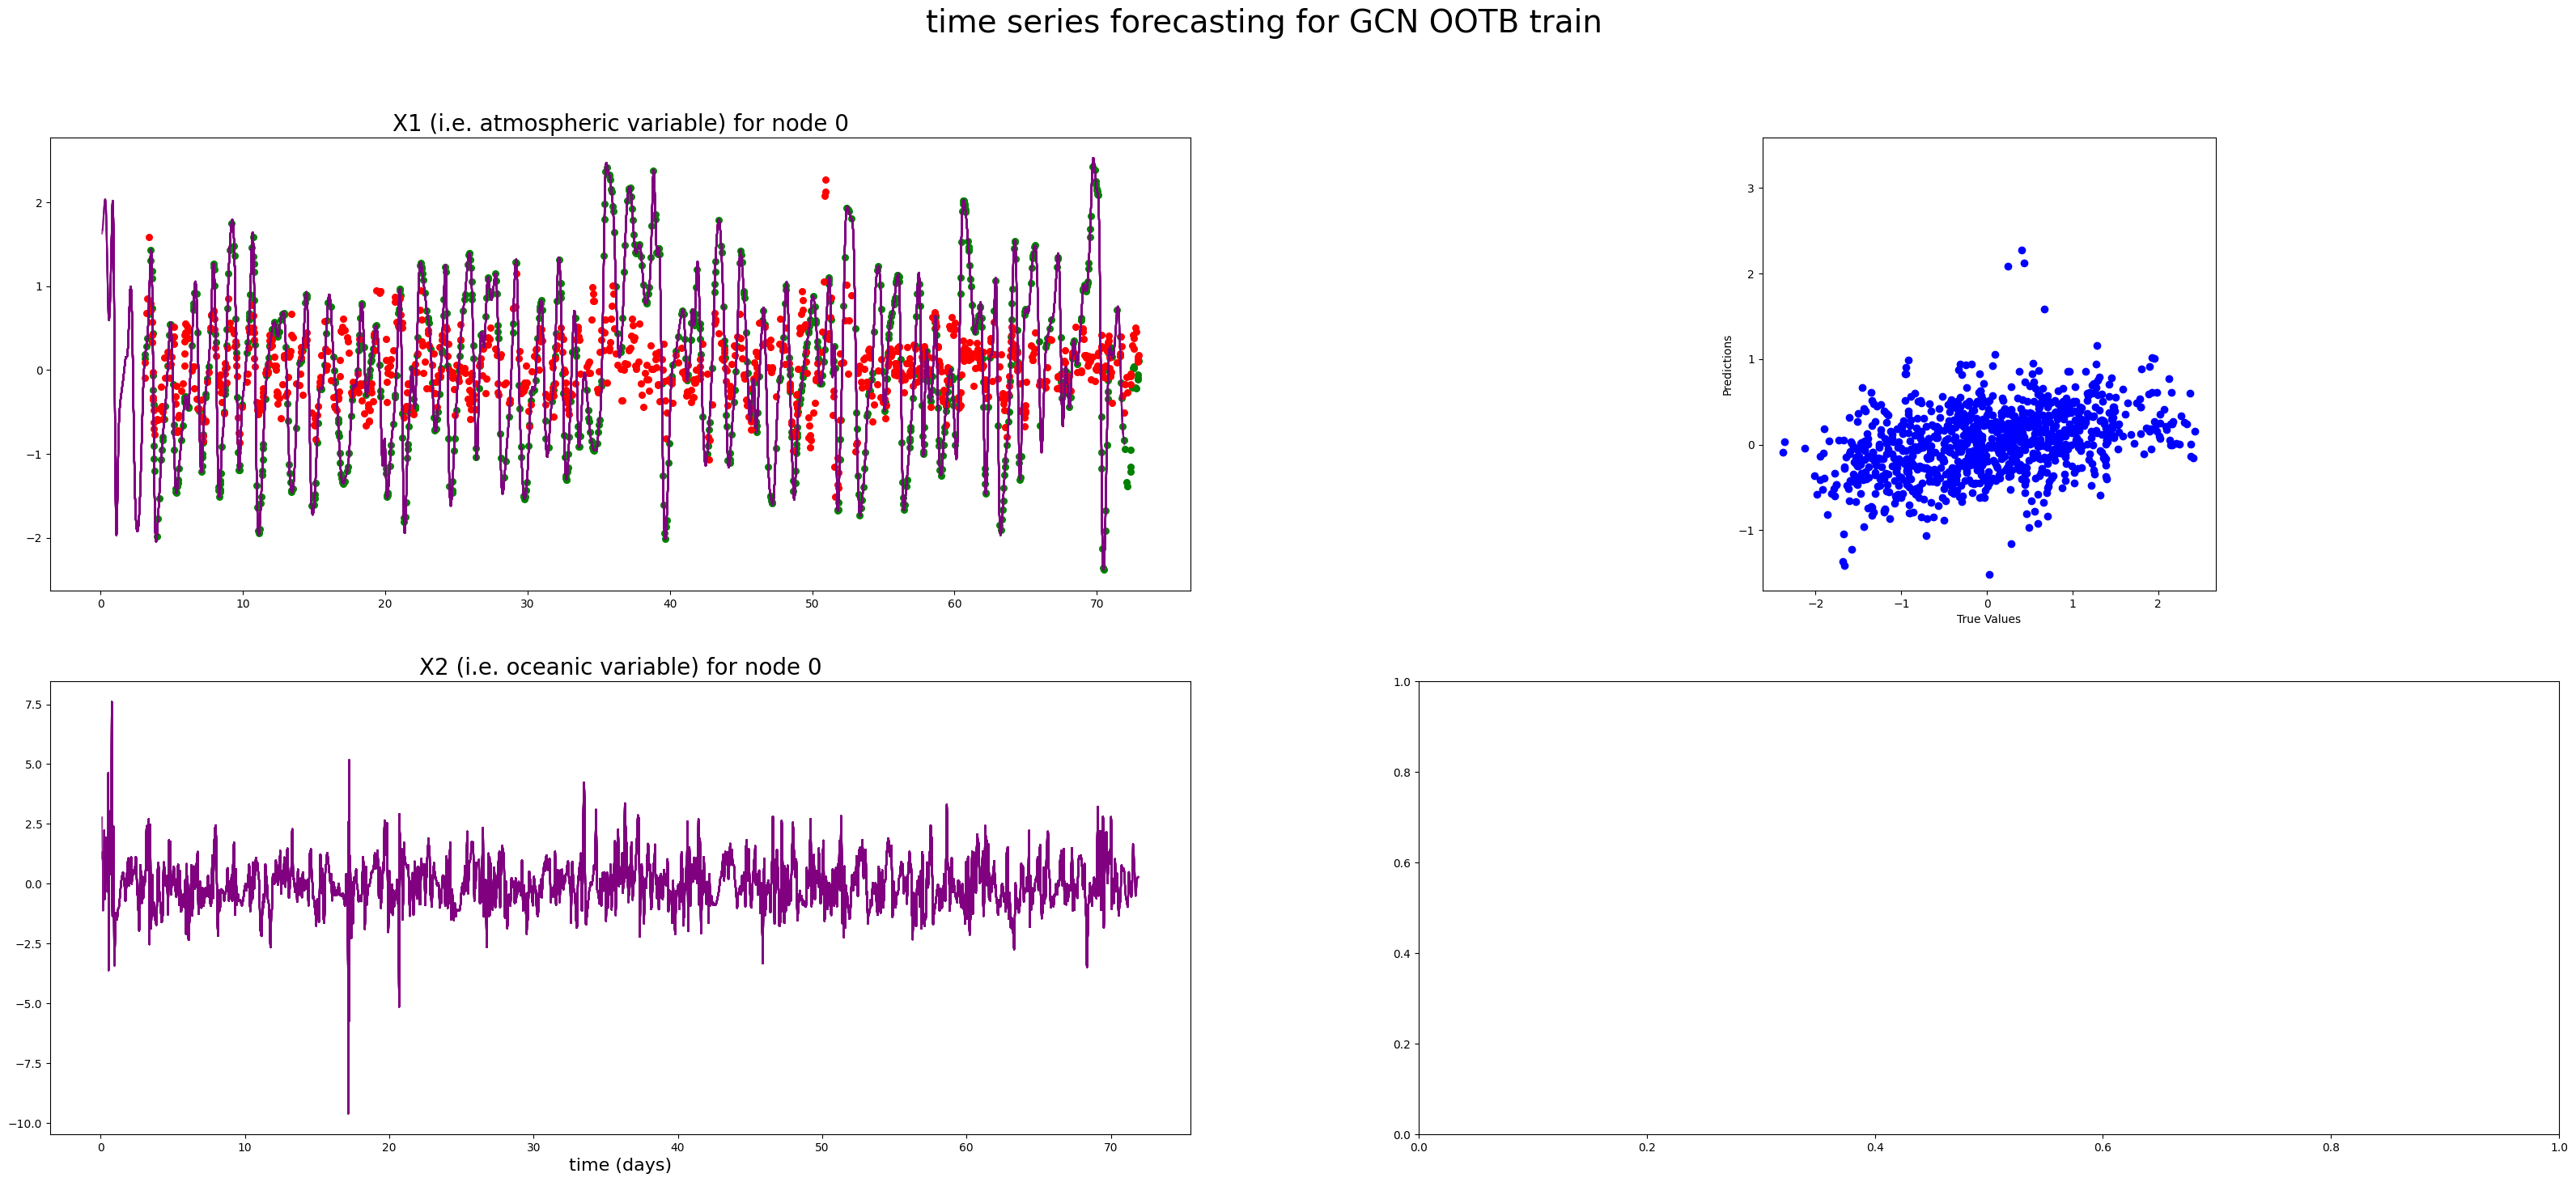

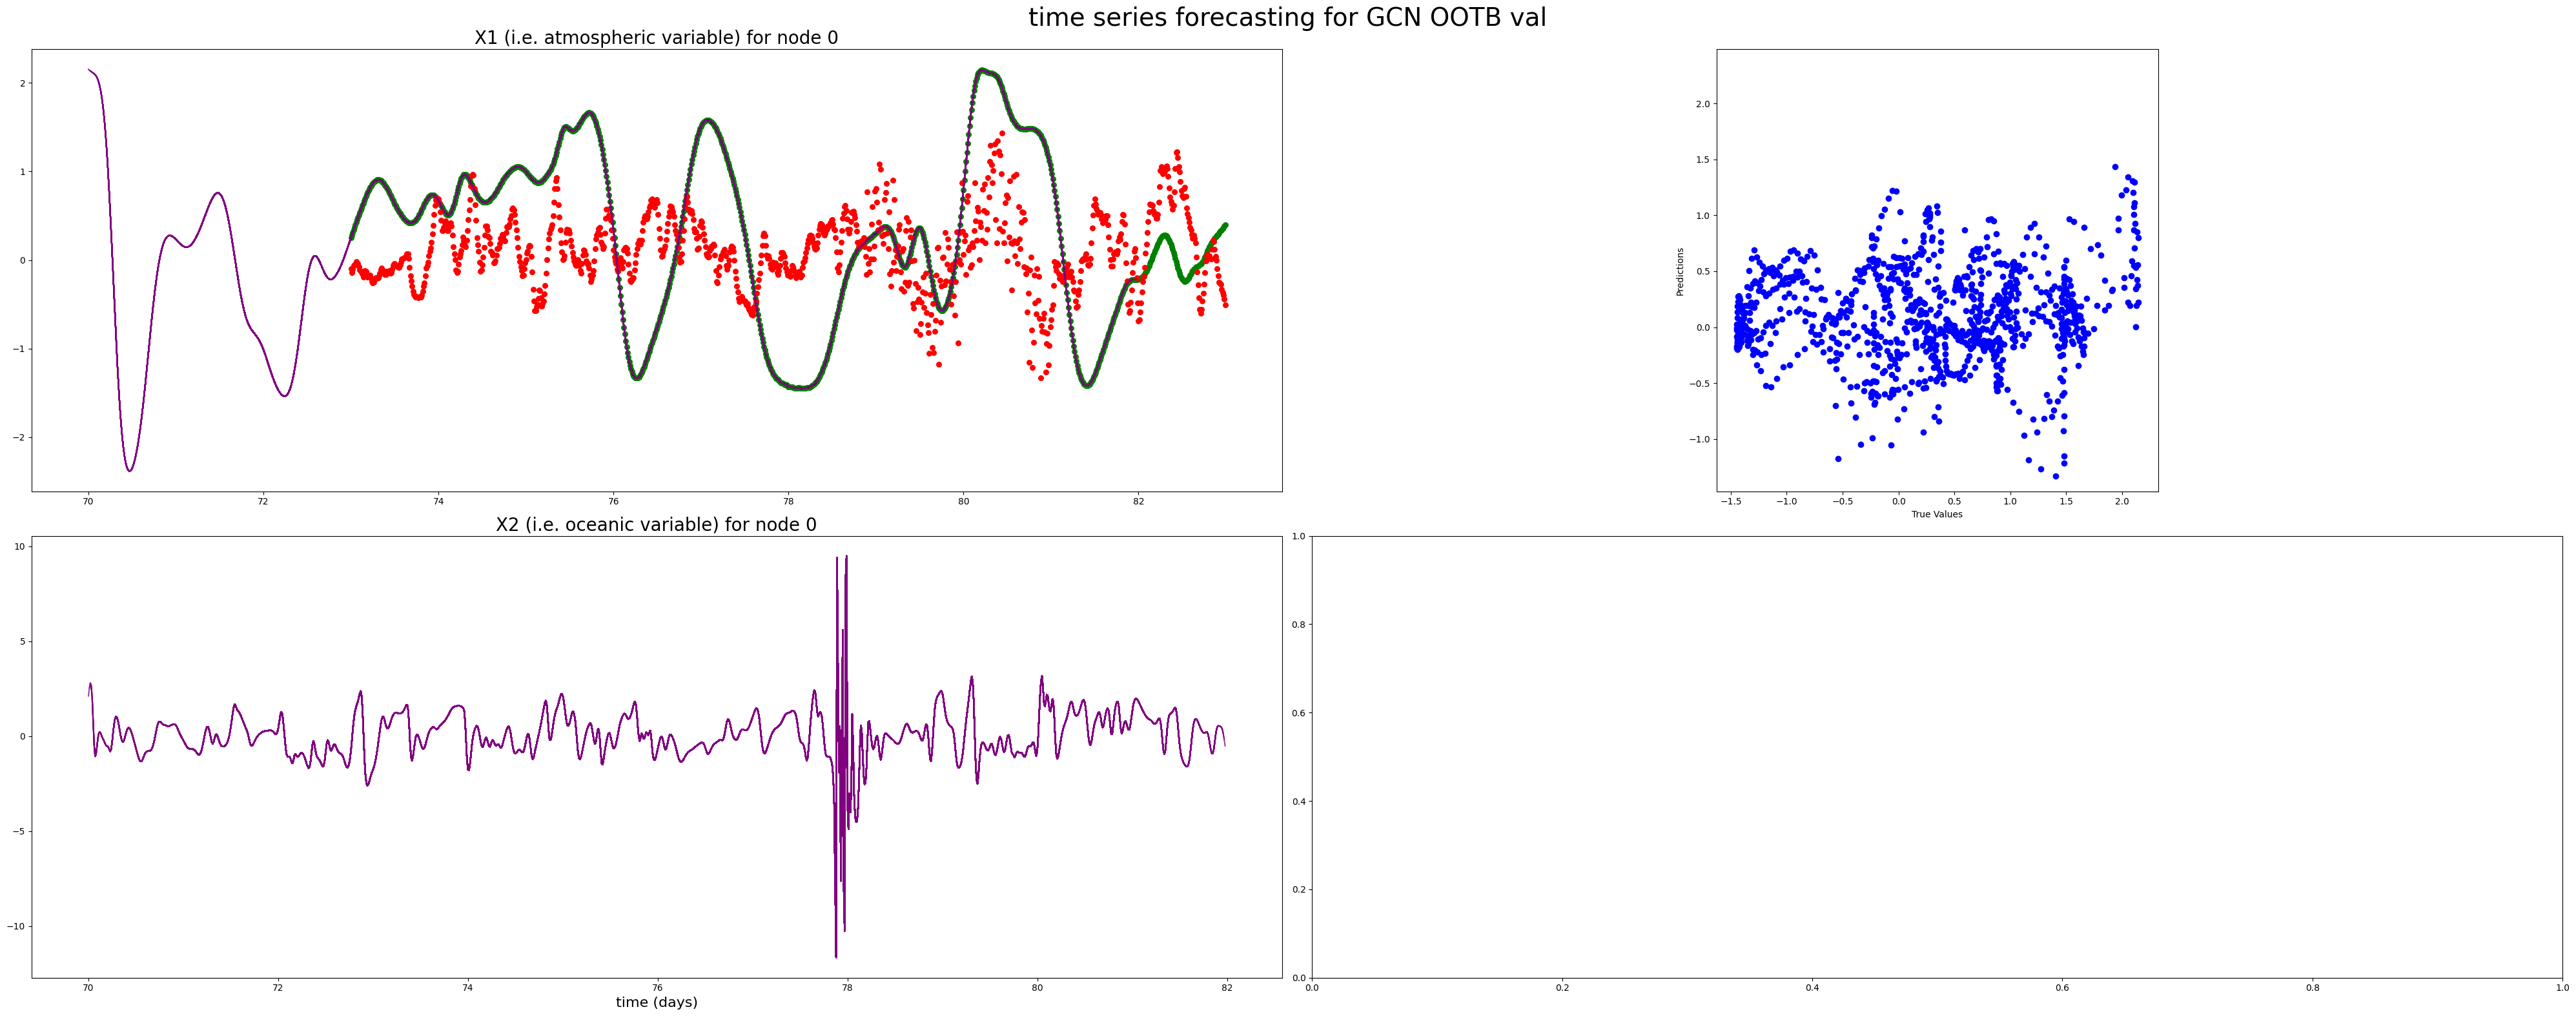

In [14]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train[:1000], val[:1000], model, history)

side note: why are the outputs different every time? is there another seed we need to set? 

zoomed in plot of predictions

In [ ]:
# set up plot
fig, axs = plt.subplots(2, 2, figsize=(20, 8))

title = "time series forecasting"
if model_name != '':
    title += " for " + model_name

fig.suptitle(title, size=28)
axs[0, 0].set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
                size=20)
axs[1, 0].set_title("X2 (i.e. oceanic variable) for node {}".format(node),
                size=20)
axs[1, 0].set_xlabel('time (days)', size=16)

for g in graph_dataset:
    axs[0, 0].plot(g.t_X,
                g.x[node][:graph_dataset.input_steps],
                label='inputs',
                c='purple', alpha=0.75)
    axs[1, 0].plot(g.t_X,
                g.x[node][graph_dataset.input_steps:],
                label='inputs',
                c='purple', alpha=0.75)
    axs[0, 0].scatter(g.t_Y,
                g.y[node][:graph_dataset.output_steps],
                label='labels',
                s=30,
                c='green')

# generate predictions
loader = Loader(dataset=graph_dataset, batch_size=batch_size, shuffle=False)
predictions = model.predict(loader.load(), steps=loader.steps_per_epoch)

# plot predictions
for i in range(len(graph_dataset)):
    g = graph_dataset[i]
    pred = predictions[i][node]
    axs[0, 0].scatter(g.t_Y, pred, label='prediction', s=30, c='red')
    axs[0, 1].scatter(g.y[node][:graph_dataset.output_steps], pred, c='blue')

# ax0.set_xlim(graph_dataset[0].t_X[0], graph_dataset[-1].t_Y[-1])
# ax1.set_xlim(graph_dataset[0].t_X[0], graph_dataset[-1].t_Y[-1])
# p1 = max(max(predicted_value), max(true_value))
# p2 = min(min(predicted_value), min(true_value))
# plt.plot([p1, p2], [p1, p2], 'b-')
axs[0, 1].plot()
axs[0, 1].set_xlabel('True Values')
axs[0, 1].set_ylabel('Predictions')
axs[0, 1].axis('equal')
axs[0, 1].axis('square')